# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [40]:
from sklearn.metrics import log_loss
from torch import nn
from torch import optim
import torch as tt
from sklearn.model_selection import validation_curve
import pandas as pd
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator
import nltk
import torch.nn.functional as F
from matplotlib import pyplot as plt
% matplotlib inline


SEED = 42
np.random.seed(SEED)



from nltk.stem.wordnet import WordNetLemmatizer
morph = WordNetLemmatizer()
punct = string.punctuation+'«»—…“”*№–'
stops = set(stopwords.words('english'))


def normalize(text):
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.lemmatize(word) for word in words if word and word not in stops]
    return words #' '.join(words)

def tokenizer(text):
    words = [word.strip(punct) for word in text.lower().split()]
    return words


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data = pd.read_csv('imdb_master.csv', encoding='latin-1', index_col = 0)

In [5]:
data.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [7]:
data.label.value_counts()

unsup    50000
neg      25000
pos      25000
Name: label, dtype: int64

In [11]:
data.to_csv('imdb_master_2.csv', encoding='utf-8')
data[data['type'] == 'test'].to_csv('test.csv', encoding='utf-8')
data[data['type'] == 'train'].to_csv('train.csv', encoding='utf-8')

In [13]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}


TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=stops)

LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])


dataset = TabularDataset('imdb_master.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

train = TabularDataset('train.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

test = TabularDataset('test.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

In [14]:
TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
len(TEXT.vocab.itos)

.vector_cache/glove.6B.zip: 862MB [02:28, 5.79MB/s]                               
100%|█████████▉| 398732/400000 [00:35<00:00, 12879.74it/s]

44431

100%|█████████▉| 398732/400000 [00:50<00:00, 12879.74it/s]

In [15]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '<eos>', 'br', 'movie', 'film', 'one', '', 'like', 'good']

In [16]:
LABEL.build_vocab(dataset)

In [17]:
train, valid = train.split(0.7, stratified=True)

In [18]:
len(TEXT.vocab.vectors)

44431

In [19]:
batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text)
)

In [20]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, embed_matrix, hidden_size, kernels, mode, n_epochs=5, fr=False):
        super(MyModel, self).__init__()
        
        if mode == 'random':
            self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.ones((vocab_size,100))), freeze=fr)
        else:
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=fr)
            
        self.n_epochs = n_epochs
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x
    
    def train_nn(self):
        min_loss = np.inf
        no_improvement = 0
        lr_list = list()
        for i in range(self.n_epochs):
            train_loss = 0
            for batch in train_iterator:
                optimizer.zero_grad()
                y_pred = self.forward(batch.text[0])
                loss = criterion(y_pred, batch.label)
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss = train_loss / len(train_iterator)
            
            val_loss_vols = 0
            with tt.no_grad():
                for batch in valid_iterator:
                    val_pred = self.forward(batch.text[0])
                    val_loss = criterion(val_pred, batch.label)
                    val_loss_vols += val_loss
            val_loss = val_loss_vols / len(valid_iterator)
            
            scheduler.step(val_loss)
            lr_list.append(optimizer.param_groups[0]['lr'])
            
            if val_loss < min_loss:
                min_loss = val_loss
                no_improvement = 0
            elif no_improvement < 10:
                no_improvement += 1
            else:
                break
                
            print(f'Epoch: {i+1:02}<--->T.Loss: {train_loss:.3f}<--->V.Loss: {val_loss:.3f}')
    
        return lr_list
    
    def evaluate(self, test_iterator, criterion):
        epoch_loss = 0
        with tt.no_grad():
                for batch in test_iterator:
                    test_pred = self.forward(batch.text[0])
                    test_loss = criterion(test_pred, batch.label)
                    epoch_loss += test_loss
                    
        return epoch_loss / len(test_iterator)

In [25]:
tt.cuda.empty_cache()

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                embed_matrix=TEXT.vocab.vectors,
                hidden_size=128,
                kernels=[2,3,4,5],
                mode='pretrained',
                n_epochs=2
               )


optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=False, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [ ]:
los = list()
l_all = list()

for mode in ['random', 'pretrained', 'weights']:
    
    tt.cuda.empty_cache()
    
    if mode == 'pretrained':
        model = MyModel(len(TEXT.vocab.itos),
                    embed_size=100,
                    embed_matrix=TEXT.vocab.vectors,
                    hidden_size=128,
                    kernels=[2,3,4,5],
                    mode=mode,
                    n_epochs=100,
                    fr=True
                   )
    else:
        model = MyModel(len(TEXT.vocab.itos),
                    embed_size=100,
                    embed_matrix=TEXT.vocab.vectors,
                    hidden_size=128,
                    kernels=[2,3,4,5],
                    mode=mode,
                    n_epochs=100
                   )
    
    optimizer = optim.Adam(model.parameters())
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=False, cooldown=5)
    criterion = nn.CrossEntropyLoss()

    lr = model.train_nn()
    l_all.append(lr)
    
    test_loss = model.evaluate(test_iterator, criterion)
    los.append(test_loss)
    
    print(f' Test.Loss: {test_loss:.3f}')

Epoch: 01<--->Train Loss: 0.875<--->Val. Loss: 0.857
Epoch: 02<--->Train Loss: 0.787<--->Val. Loss: 1.065
Epoch: 03<--->Train Loss: 0.708<--->Val. Loss: 1.403
Epoch: 04<--->Train Loss: 0.641<--->Val. Loss: 1.281
Epoch: 05<--->Train Loss: 0.562<--->Val. Loss: 1.425
Epoch: 06<--->Train Loss: 0.438<--->Val. Loss: 1.904
Epoch: 07<--->Train Loss: 0.410<--->Val. Loss: 2.113
Epoch: 08<--->Train Loss: 0.394<--->Val. Loss: 2.229
Epoch: 09<--->Train Loss: 0.384<--->Val. Loss: 2.291
Epoch: 10<--->Train Loss: 0.370<--->Val. Loss: 2.454
Epoch: 11<--->Train Loss: 0.360<--->Val. Loss: 2.486
 Test.Loss: 6.983
Epoch: 01<--->Train Loss: 0.830<--->Val. Loss: 1.116
Epoch: 02<--->Train Loss: 0.816<--->Val. Loss: 1.039
Epoch: 03<--->Train Loss: 0.813<--->Val. Loss: 1.031
Epoch: 04<--->Train Loss: 0.813<--->Val. Loss: 1.047
Epoch: 05<--->Train Loss: 0.811<--->Val. Loss: 0.897
Epoch: 06<--->Train Loss: 0.810<--->Val. Loss: 0.948
Epoch: 07<--->Train Loss: 0.811<--->Val. Loss: 0.993
Epoch: 08<--->Train Loss: 0.

Text(0, 0.5, 'L.Rate')

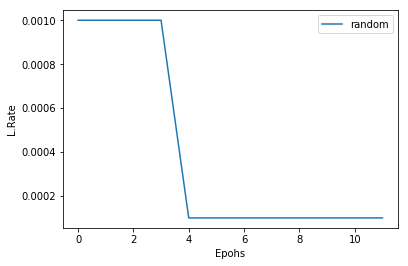

In [32]:
plt.plot(range(0, len(l_all[0])), l_all[0], label = 'random')

plt.legend()

plt.xlabel('Epohs')
plt.ylabel('L.Rate')


Text(0, 0.5, 'L.Rate')

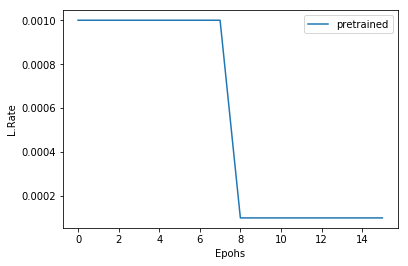

In [34]:
plt.plot(range(0, len(l_all[1])), l_all[1], label = 'pretrained')

plt.legend()

plt.xlabel('Epohs')
plt.ylabel('L.Rate')

Text(0, 0.5, 'L.Rate')

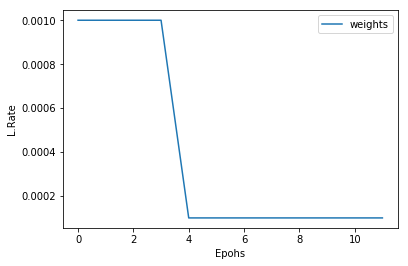

In [35]:
plt.plot(range(0, len(l_all[2])), l_all[2], label = 'weights')
plt.legend()

plt.xlabel('Epohs')
plt.ylabel('L.Rate')
#plt.title('Learning rate against the number of epoch')

Text(0, 0.5, 'L.Rate')

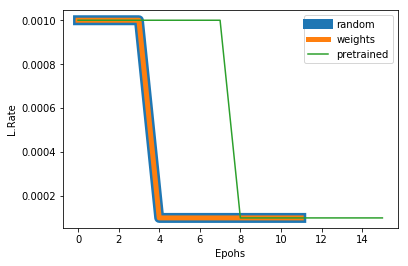

In [39]:
plt.plot(range(0, len(l_all[0])), l_all[0], label = 'random', linewidth=10)
plt.plot(range(0, len(l_all[2])), l_all[2], label = 'weights', linewidth=5)
plt.plot(range(0, len(l_all[1])), l_all[1], label = 'pretrained')

plt.legend()

plt.xlabel('Epohs')
plt.ylabel('L.Rate')

Text(0, 0.5, 'Test Loss')

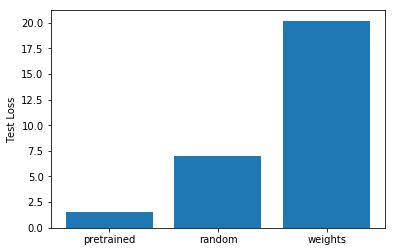

In [44]:
plt.bar(['pretrained', 'random', 'weights'], [los[1], los[0], los[2]])
plt.ylabel('Test Loss')